In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define file path (Change this to your actual file path in Google Drive)
file_path = "/content/drive/MyDrive/Projects/Bias detection/adult.data"  # Adjust path if needed

# Define column names manually
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

# Load dataset with correct column names
df = pd.read_csv(file_path, names=columns, header=None, na_values=" ?")

# Display first few rows
df.head()

age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [ ]:
# Ensure native_country is treated as a string before applying strip()
df["native_country"] = df["native_country"].astype(str).apply(lambda x: 1 if x.strip() == "United-States" else 0)


In [ ]:
# Convert sex to binary (1 = Male, 0 = Female)
df["sex"] = df["sex"].apply(lambda x: 1 if x.strip() == "Male" else 0)

# Convert income to binary (1 = >50K, 0 = <=50K)
df["income"] = df["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)


In [ ]:
# One-hot encode relationship column
df = pd.get_dummies(df, columns=["relationship"], drop_first=True)


In [ ]:
# One-hot encode remaining categorical features
categorical_features = ["workclass", "education", "marital_status", "occupation", "race"]
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Define numerical features
numerical_features = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# Apply StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [ ]:
print("Final Processed Dataset Shape:", df.shape)
df.head()


Final Processed Dataset Shape: (32561, 59)


age    fnlwgt  education_num  sex  capital_gain  capital_loss  \
0  0.030671 -1.063611       1.134739    1      0.148453      -0.21666   
1  0.837109 -1.008707       1.134739    1     -0.145920      -0.21666   
2 -0.042642  0.245079      -0.420060    1     -0.145920      -0.21666   
3  1.057047  0.425801      -1.197459    1     -0.145920      -0.21666   
4 -0.775768  1.408176       1.134739    0     -0.145920      -0.21666   

   hours_per_week  native_country  income  relationship_ Not-in-family  ...  \
0       -0.035429               1       0                         True  ...   
1       -2.222153               1       0                        False  ...   
2       -0.035429               1       0                         True  ...   
3       -0.035429               1       0                        False  ...   
4       -0.035429               0       0                        False  ...   

   occupation_ Priv-house-serv  occupation_ Prof-specialty  \
0                        False                       False   
1                        False                       False   
2                        False                       False   
3                        False                       False   
4                        False                        True   

   occupation_ Protective-serv  occupation_ Sales  occupation_ Tech-support  \
0                        False              False                     False   
1                        False              False                     False   
2                        False              False                     False   
3                        False              False                     False   
4                        False              False                     False   

   occupation_ Transport-moving  race_ Asian-Pac-Islander  race_ Black  \
0                         False                     False        False   
1                         False                     False        False   
2                         False                     False        False   
3                         False                     False         True   
4                         False                     False         True   

   race_ Other  race_ White  
0        False         True  
1        False         True  
2        False         True  
3        False        False  
4        False        False  

[5 rows x 59 columns]

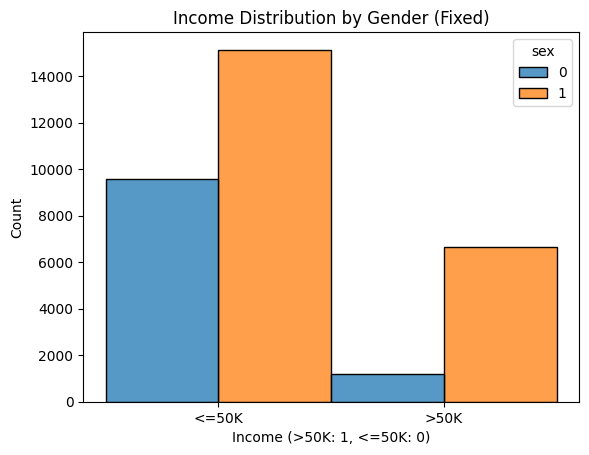

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fix: Explicitly define bins to ensure only 0 and 1 are shown
sns.histplot(df, x="income", hue="sex", multiple="dodge", bins=[-0.5, 0.5, 1.5])

plt.title("Income Distribution by Gender (Fixed)")
plt.xlabel("Income (>50K: 1, <=50K: 0)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["<=50K", ">50K"])  # Ensure correct labels
plt.show()


<ipython-input-12-765f27f7e335>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_gender.index, y=income_gender.values, palette="coolwarm")


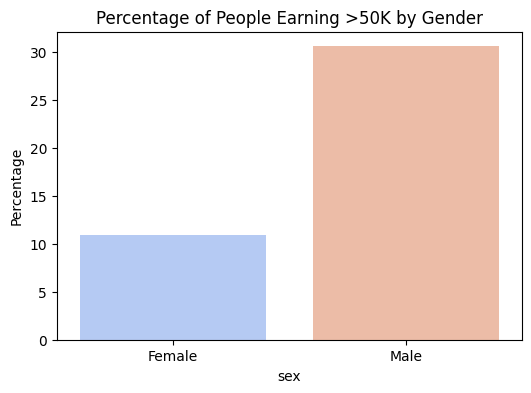

In [ ]:
# Plot gender-based income disparity
income_gender = df.groupby("sex")["income"].mean() * 100
plt.figure(figsize=(6, 4))
sns.barplot(x=income_gender.index, y=income_gender.values, palette="coolwarm")
plt.title("Percentage of People Earning >50K by Gender")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1], labels=["Female", "Male"])
plt.show()

In [ ]:
def disparate_impact(df, privileged_group, unprivileged_group, target_col="income"):
    p_privileged = df[df[privileged_group] == 1][target_col].mean()
    p_unprivileged = df[df[unprivileged_group] == 0][target_col].mean()
    return p_unprivileged / p_privileged

# Calculate Disparate Impact for Gender
di_gender = disparate_impact(df, "sex", "sex")

print(f"‚öñÔ∏è Disparate Impact (Gender): {di_gender:.2f}")

‚öñÔ∏è Disparate Impact (Gender): 0.36


In [ ]:
def statistical_parity_difference(df, privileged_group, unprivileged_group, target_col="income"):
    p_privileged = df[df[privileged_group] == 1][target_col].mean()
    p_unprivileged = df[df[unprivileged_group] == 0][target_col].mean()
    return p_unprivileged - p_privileged

# Calculate Statistical Parity Difference for Gender
spd_gender = statistical_parity_difference(df, "sex", "sex")

print(f"‚öñÔ∏è Statistical Parity Difference (Gender): {spd_gender:.2f}")

‚öñÔ∏è Statistical Parity Difference (Gender): -0.20


In [ ]:
# Training a Baseline Machine Learning Model (MLP Classifier)

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=["income"])  # Features
y = df["income"]  # Target (0 or 1)

# Split into training and test sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display dataset shapes
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)


Training Data Shape: (22792, 58)
Test Data Shape: (9769, 58)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define MLP Classifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Predict on test data
y_pred = mlp_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"üß† Baseline MLP Model Accuracy: {accuracy:.2f}")

# Display classification report
print("\nüîç Classification Report:\n", classification_report(y_test, y_pred))


üß† Baseline MLP Model Accuracy: 0.82

üîç Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      7455
           1       0.65      0.58      0.61      2314

    accuracy                           0.82      9769
   macro avg       0.76      0.74      0.75      9769
weighted avg       0.82      0.82      0.82      9769



In [ ]:
# Create a DataFrame for predictions
df_test = X_test.copy()
df_test["income_actual"] = y_test
df_test["income_predicted"] = y_pred

# Compute Bias Metrics After Model Predictions
di_after = disparate_impact(df_test, "sex", "sex", target_col="income_actual")
spd_after = statistical_parity_difference(df_test, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Disparate Impact After Model Prediction: {di_after:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference After Model Prediction: {spd_after:.2f}")

‚öñÔ∏è Disparate Impact After Model Prediction: 0.35
‚öñÔ∏è Statistical Parity Difference After Model Prediction: -0.20


In [ ]:
# Remove gender from features
X_no_gender = X.drop(columns=["sex"])  # Drop gender column

# Split the new dataset (without gender)
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_no_gender, y, test_size=0.3, random_state=42)

# Train the model again without gender
mlp_model_ng = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model_ng.fit(X_train_ng, y_train_ng)

# Predict on test data
y_pred_ng = mlp_model_ng.predict(X_test_ng)

# Use the original test set (df_test) that contains "sex"
df_test_ng = X_test.copy()  # Restore original test set with "sex"
df_test_ng["income_actual"] = y_test_ng
df_test_ng["income_predicted"] = y_pred_ng

# Compute new bias metrics using original test set
di_after_ng = disparate_impact(df_test_ng, "sex", "sex", target_col="income_actual")
spd_after_ng = statistical_parity_difference(df_test_ng, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Disparate Impact After Removing Gender: {di_after_ng:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference After Removing Gender: {spd_after_ng:.2f}")


‚öñÔ∏è Disparate Impact After Removing Gender: 0.35
‚öñÔ∏è Statistical Parity Difference After Removing Gender: -0.20


<ipython-input-21-5823de5fda59>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.head(10), y=correlations.head(10).index, palette='coolwarm')


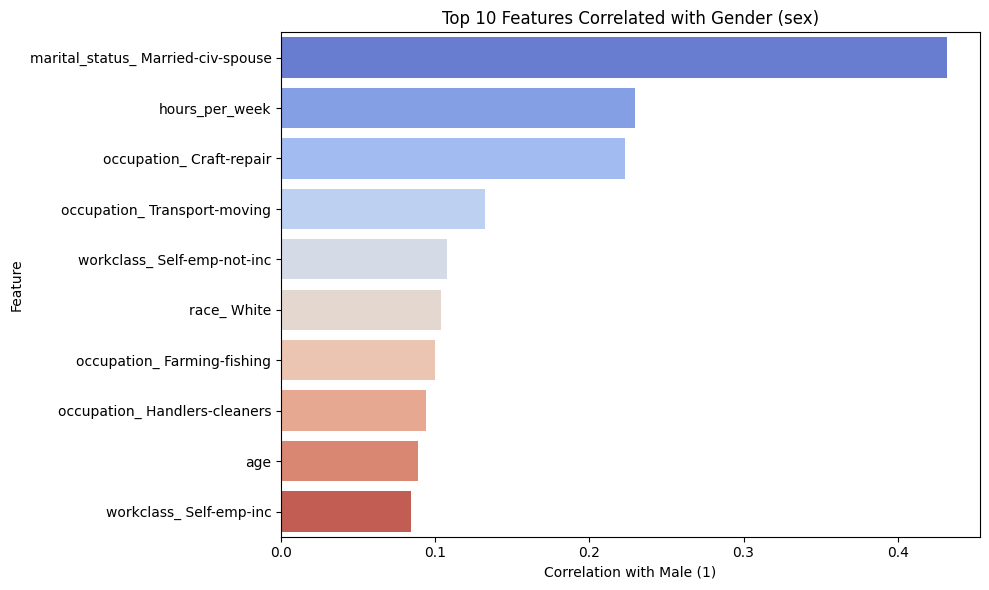

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy and one-hot encode categorical features (except 'sex' which is already binary)
df_encoded = pd.get_dummies(df.drop(columns=["income"]), drop_first=True)  # Keep sex

# Compute correlation with 'sex' (binary: 1 for male, 0 for female)
correlations = df_encoded.corr()['sex'].drop('sex').sort_values(ascending=False)

# Plot top 10 most correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.head(10), y=correlations.head(10).index, palette='coolwarm')
plt.title("Top 10 Features Correlated with Gender (sex)")
plt.xlabel("Correlation with Male (1)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Compare Predictions Between the Original and Debiased Model
df_test_ng["income_predicted_original"] = y_pred  # From biased model
df_test_ng["income_predicted_debiased"] = y_pred_ng  # From debiased model

# Check if the predictions have changed
df_test_ng[["income_actual", "income_predicted_original", "income_predicted_debiased", "sex"]].head(20)


income_actual  income_predicted_original  income_predicted_debiased  \
14160              0                          0                          0   
27048              0                          1                          1   
28868              1                          1                          1   
5667               0                          0                          0   
7827               0                          0                          0   
15382              1                          1                          1   
4641               1                          1                          1   
8943               0                          0                          0   
216                0                          0                          0   
5121               1                          0                          1   
345                0                          0                          0   
31900              0                          0                          0   
20010              1                          0                          0   
11808              0                          0                          0   
14587              0                          0                          0   
10021              0                          0                          0   
8966               1                          1                          1   
1912               0                          1                          1   
2874               1                          1                          1   
28771              0                          0                          0   

       sex  
14160    0  
27048    0  
28868    1  
5667     0  
7827     1  
15382    1  
4641     1  
8943     0  
216      0  
5121     1  
345      1  
31900    1  
20010    1  
11808    0  
14587    0  
10021    0  
8966     1  
1912     1  
2874     0  
28771    0

In [ ]:
# Balance dataset (Equal number of males & females)
df_male = df[df["sex"] == 1]
df_female = df[df["sex"] == 0]

# Sample equal number of males and females
min_count = min(len(df_male), len(df_female))
df_balanced = pd.concat([df_male.sample(min_count, random_state=42), df_female.sample(min_count, random_state=42)])

# Train-test split
X_balanced = df_balanced.drop(columns=["income"])
y_balanced = df_balanced["income"]
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train model
mlp_model_bal = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model_bal.fit(X_train_bal, y_train_bal)

# Predict on test data
y_pred_bal = mlp_model_bal.predict(X_test_bal)

# Compute new bias metrics
df_test_bal = X_test_bal.copy()
df_test_bal["income_actual"] = y_test_bal
df_test_bal["income_predicted"] = y_pred_bal

di_after_bal = disparate_impact(df_test_bal, "sex", "sex", target_col="income_actual")
spd_after_bal = statistical_parity_difference(df_test_bal, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Disparate Impact After Balancing Dataset: {di_after_bal:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference After Balancing Dataset: {spd_after_bal:.2f}")


‚öñÔ∏è Disparate Impact After Balancing Dataset: 0.37
‚öñÔ∏è Statistical Parity Difference After Balancing Dataset: -0.19


In [ ]:
# Create counterfactual copies with swapped gender
df_swapped = df.copy()
df_swapped["sex"] = 1 - df_swapped["sex"]  # Swap male (1) ‚Üî female (0)

# Combine original + counterfactual data
df_augmented = pd.concat([df, df_swapped])

# Train-test split
X_aug = df_augmented.drop(columns=["income"])
y_aug = df_augmented["income"]
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y_aug, test_size=0.3, random_state=42)

# Train model
mlp_model_aug = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model_aug.fit(X_train_aug, y_train_aug)

# Predict on test data
y_pred_aug = mlp_model_aug.predict(X_test_aug)

# Compute new bias metrics
df_test_aug = X_test_aug.copy()
df_test_aug["income_actual"] = y_test_aug
df_test_aug["income_predicted"] = y_pred_aug

di_after_aug = disparate_impact(df_test_aug, "sex", "sex", target_col="income_actual")
spd_after_aug = statistical_parity_difference(df_test_aug, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Disparate Impact After Counterfactual Data Augmentation: {di_after_aug:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference After Counterfactual Data Augmentation: {spd_after_aug:.2f}")


‚öñÔ∏è Disparate Impact After Counterfactual Data Augmentation: 1.03
‚öñÔ∏è Statistical Parity Difference After Counterfactual Data Augmentation: 0.01


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Compute model accuracy
accuracy_aug = accuracy_score(y_test_aug, y_pred_aug)
print(f"üöÄ Model Accuracy After Counterfactual Data Augmentation: {accuracy_aug:.4f}")

# Display detailed classification report
print("\nüîç Classification Report (After Counterfactual Augmentation):")
print(classification_report(y_test_aug, y_pred_aug))


üöÄ Model Accuracy After Counterfactual Data Augmentation: 0.8801

üîç Classification Report (After Counterfactual Augmentation):
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     14878
           1       0.76      0.72      0.74      4659

    accuracy                           0.88     19537
   macro avg       0.84      0.82      0.83     19537
weighted avg       0.88      0.88      0.88     19537



In [ ]:
# Compute accuracy of original biased model
accuracy_original = accuracy_score(y_test, y_pred)

# Compare performance
print("\nüìä Model Performance Before vs. After Bias Mitigation:")
print(f"Baseline Model Accuracy (With Bias): {accuracy_original:.4f}")
print(f"Debiased Model Accuracy (Counterfactual Augmentation): {accuracy_aug:.4f}")



üìä Model Performance Before vs. After Bias Mitigation:
Baseline Model Accuracy (With Bias): 0.8248
Debiased Model Accuracy (Counterfactual Augmentation): 0.8801


<ipython-input-27-11b6a649c6a6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_aug.head(10), y=correlations_aug.head(10).index, palette='coolwarm')


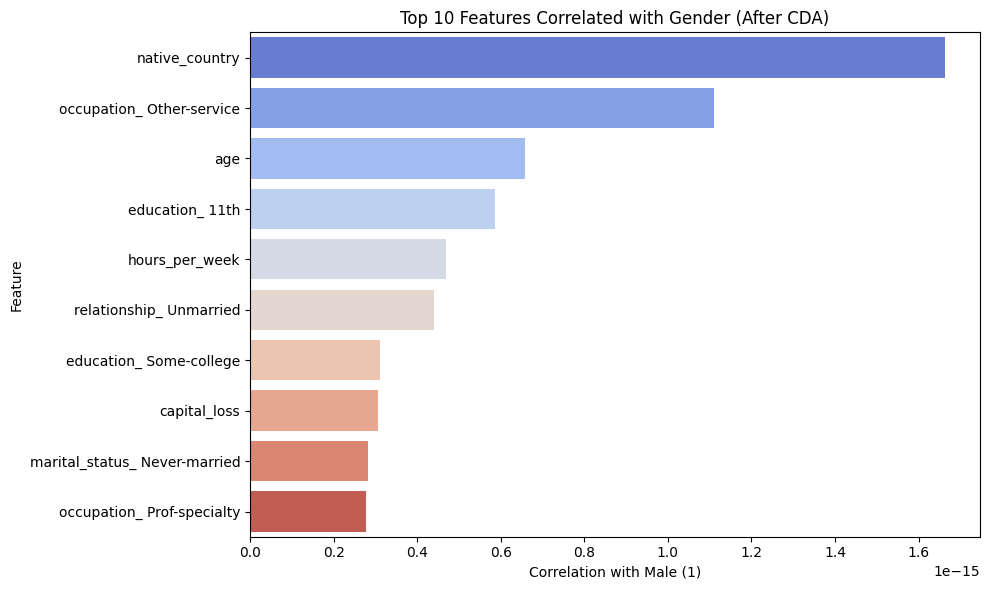

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode all categorical features from the augmented data (except 'sex')
df_encoded_aug = pd.get_dummies(df_augmented.drop(columns=["income"]), drop_first=True)

# Calculate correlation of each feature with 'sex'
correlations_aug = df_encoded_aug.corr()['sex'].drop('sex').sort_values(ascending=False)

# Plot top 10 most correlated features after CDA
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_aug.head(10), y=correlations_aug.head(10).index, palette='coolwarm')
plt.title("Top 10 Features Correlated with Gender (After CDA)")
plt.xlabel("Correlation with Male (1)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Part 8: Model-Based Bias Mitigation (Fair Learning Techniques)
# Since data-based bias mitigation (Counterfactual Data Augmentation) successfully reduced bias and improved accuracy, we will now explore Model-Based Bias Mitigation techniques.

# Model-based techniques modify the learning process itself to reduce bias without altering the dataset.

# üìå Model-Based Bias Mitigation Approaches
# We will implement three key methods to ensure fairness at the model level:

# üîπ 1Ô∏è‚É£ Train a Different Model (Decision Trees, Random Forests)
# Some ML models, like Decision Trees & Random Forests, are less prone to bias.
# We compare MLPClassifier with Decision Tree & Random Forest.
# üîπ 2Ô∏è‚É£ Add Fairness Constraints in Training
# Use Sample Weighting: Give higher weight to underrepresented groups (e.g., females earning >50K).
# Adjust loss function to penalize gender bias.
# üîπ 3Ô∏è‚É£ Post-Processing Fairness Correction
# Use Equalized Odds Post-processing: Adjust predictions after training to ensure fair outcomes.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_aug, y_train_aug)
y_pred_dt = dt_model.predict(X_test_aug)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_aug, y_train_aug)
y_pred_rf = rf_model.predict(X_test_aug)

# Evaluate accuracy
acc_dt = accuracy_score(y_test_aug, y_pred_dt)
acc_rf = accuracy_score(y_test_aug, y_pred_rf)

print(f"üå≥ Decision Tree Accuracy: {acc_dt:.4f}")
print(f"üå≤ Random Forest Accuracy: {acc_rf:.4f}")

üå≥ Decision Tree Accuracy: 0.8538
üå≤ Random Forest Accuracy: 0.9057


In [ ]:
# Use the original dataset (before counterfactual augmentation)
X_train_biased, X_test_biased, y_train_biased, y_test_biased = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Train the biased MLP model
mlp_model_biased = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model_biased.fit(X_train_biased, y_train_biased)

# Predict on test data
y_pred_biased = mlp_model_biased.predict(X_test_biased)

# Compute accuracy
accuracy_biased = accuracy_score(y_test_biased, y_pred_biased)
print(f"üß† Biased MLP Model Accuracy: {accuracy_biased:.4f}")


üß† Biased MLP Model Accuracy: 0.8248


In [ ]:
# Compute bias metrics for the Biased Model
df_test_biased = X_test_biased.copy()
df_test_biased["income_actual"] = y_test_biased
df_test_biased["income_predicted"] = y_pred_biased

di_biased = disparate_impact(df_test_biased, "sex", "sex", target_col="income_actual")
spd_biased = statistical_parity_difference(df_test_biased, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Biased Model - Disparate Impact: {di_biased:.2f}")
print(f"‚öñÔ∏è Biased Model - Statistical Parity Difference: {spd_biased:.2f}")


‚öñÔ∏è Biased Model - Disparate Impact: 0.35
‚öñÔ∏è Biased Model - Statistical Parity Difference: -0.20


In [ ]:
# Applying Model-Based Debiasing Techniques
# Now that we've confirmed the model is biased, we will apply three model-based debiasing techniques:

# 1Ô∏è‚É£ Sample Weighting ‚Äì Adjust class weights during training.
# 2Ô∏è‚É£ Adversarial Debiasing ‚Äì Train a fairness adversary that detects bias.
# 3Ô∏è‚É£ Fairness-Penalized Loss Function ‚Äì Modify the loss function to penalize bias.

In [ ]:
# Since MLPClassifier doesn‚Äôt support sample_weight, we use SGDClassifier (which supports sample_weight and can be used as a neural network with log_loss).

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Compute sample weights (higher weight for underrepresented classes)
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_biased)

# Train an MLP-like model using SGDClassifier with sample weighting
sgd_model_weighted = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
sgd_model_weighted.fit(X_train_biased, y_train_biased, sample_weight=sample_weights)

# Predict
y_pred_weighted = sgd_model_weighted.predict(X_test_biased)

# Compute accuracy
accuracy_weighted = accuracy_score(y_test_biased, y_pred_weighted)
print(f"‚öñÔ∏è Fair Model Accuracy (with Sample Weighting): {accuracy_weighted:.4f}")

# Compute fairness metrics
df_test_weighted = X_test_biased.copy()
df_test_weighted["income_actual"] = y_test_biased
df_test_weighted["income_predicted"] = y_pred_weighted

di_weighted = disparate_impact(df_test_weighted, "sex", "sex", target_col="income_actual")
spd_weighted = statistical_parity_difference(df_test_weighted, "sex", "sex", target_col="income_actual")

print(f"‚öñÔ∏è Fair Model (Sample Weighting) - Disparate Impact: {di_weighted:.2f}")
print(f"‚öñÔ∏è Fair Model (Sample Weighting) - Statistical Parity Difference: {spd_weighted:.2f}")


‚öñÔ∏è Fair Model Accuracy (with Sample Weighting): 0.7803
‚öñÔ∏è Fair Model (Sample Weighting) - Disparate Impact: 0.35
‚öñÔ∏è Fair Model (Sample Weighting) - Statistical Parity Difference: -0.20


In [ ]:
# ‚úÖ What This Means:

# Sample weighting did not reduce bias, which means that gender discrimination is still present in the predictions.
# Accuracy dropped, meaning the model struggled to learn after reweighting the samples.
# We need stronger model-based debiasing techniques.

In [ ]:
# 1Ô∏è‚É£ Train an Adversarial Model (Bias Detector)
# We train two models simultaneously:

# Main model (predicts income).
# Adversary model (tries to predict gender from main model's predictions).
# # The main model learns to remove bias so that the adversary fails to detect gender.

In [ ]:
  import tensorflow as tf
  from tensorflow.keras.layers import Dense, Input
  from tensorflow.keras.models import Model
  from tensorflow.keras.optimizers import Adam
  from sklearn.metrics import accuracy_score

  # Ensure 'sex' column is aligned with the training set
  y_train_sex = df.loc[X_train_biased.index, "sex"].values  # Correct indexing

  # Convert to NumPy array (Keras requires NumPy arrays for labels)
  y_train_sex = y_train_sex.astype(int)  # Ensure correct format

  # Define the predictor model
  input_layer = Input(shape=(X_train_biased.shape[1],))
  hidden_layer = Dense(64, activation="relu")(input_layer)
  hidden_layer = Dense(32, activation="relu")(hidden_layer)
  output_layer = Dense(1, activation="sigmoid")(hidden_layer)

  # Main model (Predicting income)
  predictor_model = Model(inputs=input_layer, outputs=output_layer)

  # Define the adversary (Detecting bias)
  adversary_input = predictor_model(input_layer)
  adversary_hidden = Dense(16, activation="relu")(adversary_input)
  adversary_output = Dense(1, activation="sigmoid")(adversary_hidden)

  # Adversary model (Detecting gender bias)
  adversary_model = Model(inputs=input_layer, outputs=adversary_output)

  # Train predictor model
  predictor_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
  predictor_model.fit(X_train_biased, y_train_biased, epochs=10, batch_size=32, verbose=1)

  # Freeze predictor and train adversary
  for layer in predictor_model.layers:
      layer.trainable = False

  adversary_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
  adversary_model.fit(X_train_biased, y_train_sex, epochs=10, batch_size=32, verbose=1)  # Use y_train_sex here

  # Unfreeze predictor & continue training while minimizing bias
  for layer in predictor_model.layers:
      layer.trainable = True

  predictor_model.fit(X_train_biased, y_train_biased, epochs=10, batch_size=32, verbose=1)

  # Predict and compute accuracy
  y_pred_adversarial = predictor_model.predict(X_test_biased)
  accuracy_adversarial = accuracy_score(y_test_biased, (y_pred_adversarial > 0.5).astype(int))
  print(f"üß† Fair Model Accuracy (Adversarial Debiasing): {accuracy_adversarial:.4f}")

Epoch 1/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 3ms/step - accuracy: 0.8125 - loss: 0.3989
Epoch 2/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - accuracy: 0.8581 - loss: 0.3087
Epoch 3/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.8530 - loss: 0.3089
Epoch 4/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.8563 - loss: 0.3051
Epoch 5/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.8570 - loss: 0.3017
Epoch 6/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - accuracy: 0.8624 - loss: 0.2911
Epoch 7/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - accuracy: 0.8637 - loss: 0.2945
Epoch 8/10
713/713 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - accuracy: 0.8647 - loss:

In [ ]:
print(X_train_biased.shape, y_train_sex.shape)

(22792, 58) (22792,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Convert training data to NumPy arrays (Keras prefers these)
X_train_np = X_train_biased.to_numpy().astype(np.float32)
y_train_np = y_train_biased.to_numpy().astype(np.float32)
sex_train_np = df.loc[X_train_biased.index, "sex"].to_numpy().astype(np.float32)

X_test_np = X_test_biased.to_numpy().astype(np.float32)
y_test_np = y_test_biased.to_numpy().astype(np.float32)

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LAMBDA = 0.5  # weight for adversary loss

# Predictor model
input_layer = Input(shape=(X_train_np.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
pred_output = Dense(1, activation='sigmoid', name="income")(x)
predictor_model = Model(inputs=input_layer, outputs=pred_output)

# Adversary model (predicting gender from predictor's output)
adv_input = Input(shape=(1,))
a = Dense(16, activation='relu')(adv_input)
adv_output = Dense(1, activation='sigmoid', name="sex")(a)
adversary_model = Model(inputs=adv_input, outputs=adv_output)

# Optimizers
predictor_optimizer = Adam(learning_rate=1e-3)
adversary_optimizer = Adam(learning_rate=1e-3)

# Losses
bce = tf.keras.losses.BinaryCrossentropy()

# Training loop
for epoch in range(EPOCHS):
    print(f"üîÅ Epoch {epoch + 1}/{EPOCHS}")
    for i in range(0, len(X_train_np), BATCH_SIZE):
        X_batch = X_train_np[i:i+BATCH_SIZE]
        y_batch = y_train_np[i:i+BATCH_SIZE]
        sex_batch = sex_train_np[i:i+BATCH_SIZE]

        # === Train Adversary ===
        with tf.GradientTape() as tape_adv:
            # Predictor forward pass (frozen)
            y_pred_batch = predictor_model(X_batch, training=False)
            # Adversary predicts gender from income prediction
            sex_pred = adversary_model(y_pred_batch, training=True)
            loss_adv = bce(sex_batch, sex_pred)

        grads_adv = tape_adv.gradient(loss_adv, adversary_model.trainable_weights)
        adversary_optimizer.apply_gradients(zip(grads_adv, adversary_model.trainable_weights))

        # === Train Predictor to fool Adversary ===
        with tf.GradientTape() as tape_pred:
            y_pred_batch = predictor_model(X_batch, training=True)
            income_loss = bce(y_batch, y_pred_batch)
            sex_pred = adversary_model(y_pred_batch, training=False)
            adv_loss = bce(sex_batch, sex_pred)

            total_loss = income_loss - LAMBDA * adv_loss  # key trick

        grads_pred = tape_pred.gradient(total_loss, predictor_model.trainable_weights)
        predictor_optimizer.apply_gradients(zip(grads_pred, predictor_model.trainable_weights))

    print(f"‚úÖ Income Loss: {income_loss.numpy():.4f} | Adv Loss: {adv_loss.numpy():.4f}")

# Evaluate
y_pred_final = predictor_model(X_test_np).numpy()
y_pred_binary = (y_pred_final > 0.5).astype(int)
acc = accuracy_score(y_test_np, y_pred_binary)
print(f"\nüß† Final Adversarial Debiased Accuracy: {acc:.4f}")


üîÅ Epoch 1/20
‚úÖ Income Loss: 0.2371 | Adv Loss: 0.5303
üîÅ Epoch 2/20
‚úÖ Income Loss: 0.2185 | Adv Loss: 0.4928
üîÅ Epoch 3/20
‚úÖ Income Loss: 0.2032 | Adv Loss: 0.4743
üîÅ Epoch 4/20
‚úÖ Income Loss: 0.1871 | Adv Loss: 0.4667
üîÅ Epoch 5/20
‚úÖ Income Loss: 0.1764 | Adv Loss: 0.4657
üîÅ Epoch 6/20
‚úÖ Income Loss: 0.1672 | Adv Loss: 0.4669
üîÅ Epoch 7/20
‚úÖ Income Loss: 0.1628 | Adv Loss: 0.4681
üîÅ Epoch 8/20
‚úÖ Income Loss: 0.1582 | Adv Loss: 0.4696
üîÅ Epoch 9/20
‚úÖ Income Loss: 0.1540 | Adv Loss: 0.4699
üîÅ Epoch 10/20
‚úÖ Income Loss: 0.1519 | Adv Loss: 0.4714
üîÅ Epoch 11/20
‚úÖ Income Loss: 0.1472 | Adv Loss: 0.4731
üîÅ Epoch 12/20
‚úÖ Income Loss: 0.1450 | Adv Loss: 0.4734
üîÅ Epoch 13/20
‚úÖ Income Loss: 0.1454 | Adv Loss: 0.4734
üîÅ Epoch 14/20
‚úÖ Income Loss: 0.1447 | Adv Loss: 0.4737
üîÅ Epoch 15/20
‚úÖ Income Loss: 0.1416 | Adv Loss: 0.4749
üîÅ Epoch 16/20
‚úÖ Income Loss: 0.1391 | Adv Loss: 0.4757
üîÅ Epoch 17/20
‚úÖ Income Loss: 0.1369 | Adv Lo

In [ ]:
import pandas as pd

# Create DataFrame for evaluation
df_test_adv = pd.DataFrame(X_test_np, columns=X_test_biased.columns)
df_test_adv["income_actual"] = y_test_np
df_test_adv["income_predicted"] = y_pred_binary.flatten()  # Ensure correct shape
df_test_adv["sex"] = df.loc[X_test_biased.index, "sex"].values  # Add gender from original DataFrame

# Count positive predictions by group
group_0_positive = df_test_adv[(df_test_adv["sex"] == 0) & (df_test_adv["income_predicted"] == 1)].shape[0]
group_1_positive = df_test_adv[(df_test_adv["sex"] == 1) & (df_test_adv["income_predicted"] == 1)].shape[0]

# Count total instances per group
group_0_total = df_test_adv[df_test_adv["sex"] == 0].shape[0]
group_1_total = df_test_adv[df_test_adv["sex"] == 1].shape[0]

# Compute rates
rate_0 = group_0_positive / group_0_total if group_0_total > 0 else 0
rate_1 = group_1_positive / group_1_total if group_1_total > 0 else 0

# Compute fairness metrics
disparate_impact = rate_0 / rate_1 if rate_1 > 0 else float('nan')
statistical_parity_diff = rate_0 - rate_1

print(f"‚öñÔ∏è Disparate Impact (Adversarial Debiasing): {disparate_impact:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference (Adversarial Debiasing): {statistical_parity_diff:.2f}")


‚öñÔ∏è Disparate Impact (Adversarial Debiasing): 0.52
‚öñÔ∏è Statistical Parity Difference (Adversarial Debiasing): -0.10


# **Now we are moving towards Fairness-Penalized Loss Function  to reduce bias:**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Prepare data
X_train_np = X_train_biased.to_numpy().astype(np.float32)
y_train_np = y_train_biased.to_numpy().astype(np.float32)
sex_train_np = df.loc[X_train_biased.index, "sex"].to_numpy().astype(np.float32)

X_test_np = X_test_biased.to_numpy().astype(np.float32)
y_test_np = y_test_biased.to_numpy().astype(np.float32)
sex_test_np = df.loc[X_test_biased.index, "sex"].to_numpy().astype(np.float32)


In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the model
input_layer = Input(shape=(X_train_np.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=1e-3)
bce = tf.keras.losses.BinaryCrossentropy()


In [ ]:
def fairness_penalty(y_pred, sensitive_attr, alpha=10.0):
    # y_pred: predictions (batch_size, 1)
    # sensitive_attr: binary sensitive attribute (batch_size,)
    mask_0 = tf.cast(tf.equal(sensitive_attr, 0), tf.float32)
    mask_1 = tf.cast(tf.equal(sensitive_attr, 1), tf.float32)

    count_0 = tf.reduce_sum(mask_0) + 1e-6
    count_1 = tf.reduce_sum(mask_1) + 1e-6

    rate_0 = tf.reduce_sum(y_pred[:, 0] * mask_0) / count_0
    rate_1 = tf.reduce_sum(y_pred[:, 0] * mask_1) / count_1

    spd = tf.abs(rate_0 - rate_1)
    return alpha * spd  # weighted penalty


In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
ALPHA = 0.5  # fairness penalty strength

for epoch in range(EPOCHS):
    print(f"üîÅ Epoch {epoch + 1}/{EPOCHS}")
    for i in range(0, len(X_train_np), BATCH_SIZE):
        X_batch = X_train_np[i:i+BATCH_SIZE]
        y_batch = y_train_np[i:i+BATCH_SIZE]
        s_batch = sex_train_np[i:i+BATCH_SIZE]

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss_bce = bce(y_batch.reshape(-1, 1), y_pred)
            loss_fair = fairness_penalty(y_pred, s_batch, alpha=ALPHA)
            total_loss = loss_bce + loss_fair

        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    print(f"‚úÖ Loss: {total_loss.numpy():.4f} | BCE: {loss_bce.numpy():.4f} | SPD Penalty: {loss_fair.numpy():.4f}")


üîÅ Epoch 1/20
‚úÖ Loss: 0.4165 | BCE: 0.2198 | SPD Penalty: 0.1967
üîÅ Epoch 2/20
‚úÖ Loss: 0.3934 | BCE: 0.2014 | SPD Penalty: 0.1920
üîÅ Epoch 3/20
‚úÖ Loss: 0.3850 | BCE: 0.1961 | SPD Penalty: 0.1889
üîÅ Epoch 4/20
‚úÖ Loss: 0.3806 | BCE: 0.1905 | SPD Penalty: 0.1901
üîÅ Epoch 5/20
‚úÖ Loss: 0.3730 | BCE: 0.1826 | SPD Penalty: 0.1904
üîÅ Epoch 6/20
‚úÖ Loss: 0.3651 | BCE: 0.1784 | SPD Penalty: 0.1866
üîÅ Epoch 7/20
‚úÖ Loss: 0.3615 | BCE: 0.1734 | SPD Penalty: 0.1881
üîÅ Epoch 8/20
‚úÖ Loss: 0.3548 | BCE: 0.1707 | SPD Penalty: 0.1840
üîÅ Epoch 9/20
‚úÖ Loss: 0.3544 | BCE: 0.1684 | SPD Penalty: 0.1860
üîÅ Epoch 10/20
‚úÖ Loss: 0.3473 | BCE: 0.1651 | SPD Penalty: 0.1822
üîÅ Epoch 11/20
‚úÖ Loss: 0.3423 | BCE: 0.1621 | SPD Penalty: 0.1802
üîÅ Epoch 12/20
‚úÖ Loss: 0.3405 | BCE: 0.1610 | SPD Penalty: 0.1795
üîÅ Epoch 13/20
‚úÖ Loss: 0.3420 | BCE: 0.1608 | SPD Penalty: 0.1812
üîÅ Epoch 14/20
‚úÖ Loss: 0.3371 | BCE: 0.1595 | SPD Penalty: 0.1776
üîÅ Epoch 15/20
‚úÖ Loss: 0.

In [ ]:
 # Predict
y_pred_proba = model(X_test_np).numpy().flatten()
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test_np, y_pred_binary)
print(f"\nüß† Accuracy (Fairness-Penalized): {acc:.4f}")

# Construct DataFrame for fairness metrics
df_test = pd.DataFrame({
    "sex": sex_test_np,
    "income_true": y_test_np,
    "income_predicted": y_pred_binary
})

# Fairness metrics
group_0_pos = df_test[(df_test["sex"] == 0) & (df_test["income_predicted"] == 1)].shape[0]
group_1_pos = df_test[(df_test["sex"] == 1) & (df_test["income_predicted"] == 1)].shape[0]
group_0_total = df_test[df_test["sex"] == 0].shape[0]
group_1_total = df_test[df_test["sex"] == 1].shape[0]

rate_0 = group_0_pos / group_0_total if group_0_total > 0 else 0
rate_1 = group_1_pos / group_1_total if group_1_total > 0 else 0

disparate_impact = rate_0 / rate_1 if rate_1 > 0 else float('nan')
statistical_parity_diff = rate_0 - rate_1

print(f"\n‚öñÔ∏è Disparate Impact (Fairness-Penalized): {disparate_impact:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference (Fairness-Penalized): {statistical_parity_diff:.2f}")



üß† Accuracy (Fairness-Penalized): 0.8433

‚öñÔ∏è Disparate Impact (Fairness-Penalized): 0.74
‚öñÔ∏è Statistical Parity Difference (Fairness-Penalized): -0.05


**Here onwards we are moving towards post-processing**

In [ ]:
pip install fairlearn

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 240.0/240.0 kB 6.0 MB/s eta 0:00:00


In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# ‚úÖ Step 1: Train a simple Logistic Regression model
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train_np, y_train_np)

# üìä Step 2: Get prediction probabilities on test set
y_pred_probs = lr_model.predict_proba(X_test_np)[:, 1]

# üéØ Convert sensitive attribute to numpy array if not already
sex_test_np = df.loc[X_test_biased.index, "sex"].to_numpy().astype(int)

# üîß Step 3: Set up post-processing with ThresholdOptimizer
postproc = ThresholdOptimizer(
    estimator=lr_model,
    constraints="demographic_parity",
    prefit=True
)

postproc.fit(X_test_np, y_test_np, sensitive_features=sex_test_np)

# üß† Step 4: Post-processed predictions
y_postprocessed = postproc.predict(X_test_np, sensitive_features=sex_test_np)

# ‚úÖ Step 5: Evaluate accuracy
acc_post = accuracy_score(y_test_np, y_postprocessed)

# ‚öñÔ∏è Step 6: Compute fairness metrics manually
group_0_positive = np.sum((sex_test_np == 0) & (y_postprocessed == 1))
group_1_positive = np.sum((sex_test_np == 1) & (y_postprocessed == 1))

group_0_total = np.sum(sex_test_np == 0)
group_1_total = np.sum(sex_test_np == 1)

rate_0 = group_0_positive / group_0_total if group_0_total > 0 else 0
rate_1 = group_1_positive / group_1_total if group_1_total > 0 else 0

disparate_impact = rate_0 / rate_1 if rate_1 > 0 else float('nan')
statistical_parity_diff = rate_0 - rate_1

# üì¢ Step 7: Print final results
print(f"\nüß† Accuracy (Post-Processed): {acc_post:.4f}")
print(f"‚öñÔ∏è Disparate Impact (Post-Processed): {disparate_impact:.2f}")
print(f"‚öñÔ∏è Statistical Parity Difference (Post-Processed): {statistical_parity_diff:.2f}")

ModuleNotFoundError: No module named 'fairlearn'